## Predicting logP for JAK2 with RNNs and SMILES strings 

This notebook demonstrates how to build predictive recurrent neural network for SMILES strings. We will build classification model for logP with OpenChem Toolkit (https://github.com/Mariewelt/OpenChem)

In [1]:
# Cloning OpenChem. Comment this line if you already cloned the repository
! git clone --branch develop https://github.com/Mariewelt/OpenChem.git

fatal: destination path 'OpenChem' already exists and is not an empty directory.


In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


## Imports

In [3]:
import sys
import os

In [4]:
sys.path.pop(sys.path.index('/home/mariewelt/Work/tmp/OpenChem'))

'/home/mariewelt/Work/tmp/OpenChem'

In [5]:
sys.path.append('/home/mariewelt/Work/tmp/ReLeaSE/OpenChem')

In [6]:
from openchem.models.Smiles2Label import Smiles2Label
from openchem.modules.encoders.rnn_encoder import RNNEncoder
from openchem.modules.mlp.openchem_mlp import OpenChemMLP
from openchem.data.smiles_data_layer import SmilesDataset
from openchem.data.utils import save_smiles_property_file
from openchem.data.utils import create_loader
from openchem.models.openchem_model import build_training, fit, evaluate

In [7]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

In [8]:
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import copy
import pickle

## Reading data

In [9]:
from openchem.data.utils import read_smiles_property_file
data = read_smiles_property_file('./data/logP_labels.csv', 
                                 cols_to_read=[1, 2], keep_header=False)
smiles = data[0]
labels = data[1].astype('float32')

(array([1.300e+01, 1.420e+02, 9.030e+02, 3.624e+03, 5.417e+03, 2.995e+03,
        7.490e+02, 2.700e+02, 5.800e+01, 5.000e+00]),
 array([-5.4       , -3.7310002 , -2.062     , -0.39300007,  1.2759999 ,
         2.945     ,  4.614     ,  6.283     ,  7.952     ,  9.621     ,
        11.29      ], dtype=float32),
 <a list of 10 Patch objects>)

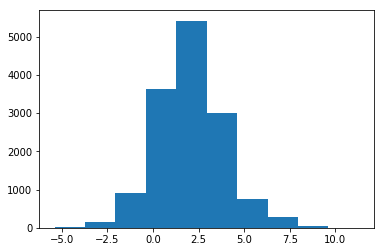

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(labels)

In [11]:
from openchem.data.utils import get_tokens
tokens, _, _ = get_tokens(smiles)
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
tokens = ''.join(tokens) + ' '

## Model architecture

Here we define the architecture of our Recurrent Neural Network (RNN). This model solve the regression problem, i.e. predicts values of logP directly from SMILES (no need to calculated descriptors). 

We will use 2 unidirectional LSTM layers with hidden size of 128 each. Embedding size is 128. Dense layers is a Multi-layer Perceptron with with hidden size of 128 and ReLU activation function. The loss function is simple MSE (mean squared error).

We will use OpenChem toolkit to train the model. For more details on OpenChem visit: https://mariewelt.github.io/OpenChem/

The architecture of the network is shown below:

<img src="./figures/predictor_figure.png">

In [12]:
import torch
from openchem.utils.utils import identity
from openchem.modules.embeddings.basic_embedding import Embedding
model_object = Smiles2Label

n_hidden = 128
batch_size = 128
num_epochs = 26
lr = 0.005

model_params = {
    'use_cuda': True,
    'random_seed': 42,
    'world_size': 1,
    'task': 'regression',
    'data_layer': SmilesDataset,
    'use_clip_grad': False,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'logdir': './checkpoints/logP/',
    'print_every': 1,
    'save_every': 5,
    'train_data_layer': None,
    'val_data_layer': None,
    'eval_metrics': r2_score,
    'criterion': nn.MSELoss(),
    'optimizer': Adam,
    'optimizer_params': {
        'lr': lr,
    },
    'lr_scheduler': ExponentialLR,
    'lr_scheduler_params': {
        'gamma': 0.98
    },
    'embedding': Embedding,
    'embedding_params': {
        'num_embeddings': len(tokens),
        'embedding_dim': n_hidden,
        'padding_idx': tokens.index(' ')
    },
    'encoder': RNNEncoder,
    'encoder_params': {
        'input_size': n_hidden,
        'layer': "LSTM",
        'encoder_dim': n_hidden,
        'n_layers': 2,
        'dropout': 0.8,
        'is_bidirectional': False
    },
    'mlp': OpenChemMLP,
    'mlp_params': {
        'input_size': n_hidden,
        'n_layers': 2,
        'hidden_size': [n_hidden, 1],
        'activation': [F.relu, identity],
        'dropout': 0.0
    }
}

In [22]:
pickle.dump(model_params, open('./checkpoints/logP/model_parameters.pkl', 'wb'))

In [13]:
try:
    os.stat(model_params['logdir'])
except:
    os.mkdir(model_params['logdir'])

In [14]:
log_dir = './checkpoints/logP/'

In [15]:
tmp_data_dir = './data/tmp/'
try:
    os.stat(tmp_data_dir)
except:
    os.mkdir(tmp_data_dir)

## Initializing data splitter for cross validation

In [16]:
from sklearn.model_selection import KFold, train_test_split

cross_validation_split = KFold(n_splits=5, shuffle=True)

In [17]:
data = list(cross_validation_split.split(smiles, labels))

## Training cross-validated models

In [18]:
import os
i = 0
models = []
results = []
for split in data:
    print('Cross validation, fold number ' + str(i) + ' in progress...')
    train, test = split
    X_train = smiles[train]
    y_train = labels[train].reshape(-1)
    X_test = smiles[test]
    y_test = labels[test].reshape(-1)
    save_smiles_property_file(tmp_data_dir + str(i) + '_train.smi', 
                              X_train, y_train.reshape(-1, 1))
    save_smiles_property_file(tmp_data_dir + str(i) + '_test.smi', 
                              X_test, y_test.reshape(-1, 1))

    train_dataset = SmilesDataset(tmp_data_dir + str(i) + '_train.smi',
                           delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                 flip=False,)
    train_dataset.target = train_dataset.target
    test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                       delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                flip=False)
    test_dataset.target = test_dataset.target
    model_params['train_data_layer'] = train_dataset
    model_params['val_data_layer'] = test_dataset
    model_params['logdir'] = log_dir + 'fold_' + str(i)  
    ckpt_dir = model_params['logdir'] + '/checkpoint/'
    try:
        os.stat(ckpt_dir)
    except:
        os.mkdir(model_params['logdir'])
        os.mkdir(ckpt_dir)
    train_loader = create_loader(train_dataset,
                             batch_size=model_params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             pin_memory=True,
                             sampler=None)
    val_loader = create_loader(test_dataset,
                           batch_size=model_params['batch_size'],
                           shuffle=False,
                           num_workers=1,
                           pin_memory=True)
    models.append(model_object(params=model_params).cuda())
    criterion, optimizer, lr_scheduler = build_training(models[i], model_params)
    results.append(fit(models[i], lr_scheduler, train_loader, optimizer, criterion,
        model_params, eval=True, val_loader=val_loader))
    
    i = i+1

Cross validation, fold number 0 in progress...
TRAINING: [Time: 0m 3s, Epoch: 0, Progress: 0%, Loss: 2.3622]
EVALUATION: [Time: 0m 0s, Loss: 1.2985, Metrics: 0.6359]
TRAINING: [Time: 0m 7s, Epoch: 1, Progress: 3%, Loss: 1.0032]
EVALUATION: [Time: 0m 0s, Loss: 0.8611, Metrics: 0.7517]
TRAINING: [Time: 0m 11s, Epoch: 2, Progress: 7%, Loss: 0.7285]
EVALUATION: [Time: 0m 0s, Loss: 0.5726, Metrics: 0.8392]
TRAINING: [Time: 0m 15s, Epoch: 3, Progress: 11%, Loss: 0.5623]
EVALUATION: [Time: 0m 0s, Loss: 0.6304, Metrics: 0.8219]
TRAINING: [Time: 0m 20s, Epoch: 4, Progress: 15%, Loss: 0.5127]
EVALUATION: [Time: 0m 0s, Loss: 0.5067, Metrics: 0.8545]
TRAINING: [Time: 0m 24s, Epoch: 5, Progress: 19%, Loss: 0.4698]
EVALUATION: [Time: 0m 0s, Loss: 0.4158, Metrics: 0.8812]
TRAINING: [Time: 0m 28s, Epoch: 6, Progress: 23%, Loss: 0.4491]
EVALUATION: [Time: 0m 0s, Loss: 0.4470, Metrics: 0.8731]
TRAINING: [Time: 0m 32s, Epoch: 7, Progress: 26%, Loss: 0.4129]
EVALUATION: [Time: 0m 0s, Loss: 0.4512, Metrics

EVALUATION: [Time: 0m 0s, Loss: 0.3136, Metrics: 0.9062]
TRAINING: [Time: 1m 9s, Epoch: 15, Progress: 57%, Loss: 0.2682]
EVALUATION: [Time: 0m 0s, Loss: 0.3307, Metrics: 0.9004]
TRAINING: [Time: 1m 13s, Epoch: 16, Progress: 61%, Loss: 0.2546]
EVALUATION: [Time: 0m 0s, Loss: 0.3475, Metrics: 0.8947]
TRAINING: [Time: 1m 18s, Epoch: 17, Progress: 65%, Loss: 0.2429]
EVALUATION: [Time: 0m 0s, Loss: 0.2908, Metrics: 0.9126]
TRAINING: [Time: 1m 22s, Epoch: 18, Progress: 69%, Loss: 0.2320]
EVALUATION: [Time: 0m 0s, Loss: 0.3450, Metrics: 0.8972]
TRAINING: [Time: 1m 27s, Epoch: 19, Progress: 73%, Loss: 0.2424]
EVALUATION: [Time: 0m 0s, Loss: 0.3765, Metrics: 0.8868]
TRAINING: [Time: 1m 31s, Epoch: 20, Progress: 76%, Loss: 0.2462]
EVALUATION: [Time: 0m 0s, Loss: 0.4004, Metrics: 0.8789]
TRAINING: [Time: 1m 35s, Epoch: 21, Progress: 80%, Loss: 0.2327]
EVALUATION: [Time: 0m 0s, Loss: 0.3599, Metrics: 0.8912]
TRAINING: [Time: 1m 40s, Epoch: 22, Progress: 84%, Loss: 0.2177]
EVALUATION: [Time: 0m 0s,

## Evaluating the models

In [19]:
import numpy as np
rmse = []
auc_score = []
for i in range(5):
    test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                                 delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                flip=False)
    test_dataset.target = test_dataset.target
    val_loader = create_loader(test_dataset,
                               batch_size=model_params['batch_size'],
                               shuffle=False,
                               num_workers=1,
                               pin_memory=True)
    metrics = evaluate(models[i], val_loader, criterion)
    rmse.append(np.sqrt(metrics[0]))
    auc_score.append(metrics[1])

EVALUATION: [Time: 0m 0s, Loss: 0.3353, Metrics: 0.9043]
EVALUATION: [Time: 0m 0s, Loss: 0.2759, Metrics: 0.9111]
EVALUATION: [Time: 0m 0s, Loss: 0.2826, Metrics: 0.9148]
EVALUATION: [Time: 0m 0s, Loss: 0.4066, Metrics: 0.8843]
EVALUATION: [Time: 0m 0s, Loss: 0.3524, Metrics: 0.8927]


In [20]:
print("Cross-validated RMSE: ",  np.mean(rmse))
print("Cross-validated R2 score: ", np.mean(auc_score))

Cross-validated RMSE:  0.5734339993856861
Cross-validated R2 score:  0.9014448637134084


In [21]:
! mv ./checkpoints/logP/fold_0/checkpoint/epoch_25 ./checkpoints/logP/fold_0.pkl
! mv ./checkpoints/logP/fold_1/checkpoint/epoch_25 ./checkpoints/logP/fold_1.pkl
! mv ./checkpoints/logP/fold_2/checkpoint/epoch_25 ./checkpoints/logP/fold_2.pkl
! mv ./checkpoints/logP/fold_3/checkpoint/epoch_25 ./checkpoints/logP/fold_3.pkl
! mv ./checkpoints/logP/fold_4/checkpoint/epoch_25 ./checkpoints/logP/fold_4.pkl